# Question 1

In [1]:
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader


def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func: {f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed

In [2]:
def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test

In [3]:
class MnistDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        if not isinstance(X, torch.Tensor):
            self.X = torch.tensor(X, dtype=torch.float)
        else:
            self.X = X
        
        if not isinstance(y, torch.Tensor):
            self.y = torch.tensor(y, dtype=torch.long)
        else:
            self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


## (a)

In [141]:
X_train, y_train, X_test, y_test = load_dataset("mnist.pkl")
X_train = X_train.reshape(X_train.shape[0], -1) / torch.max(X_train)
X_test = X_test.reshape(X_test.shape[0], -1) / torch.max(X_test)

## (b)

**Complete the following Python class for training/evaluation**

In [133]:
from tqdm import tqdm 

class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2):
        self.model = model
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model.__class__.__name__} - Number of parameters: {num_params}")
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), learning_rate, weight_decay=l2)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
    
    @timeit
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=False):
            # enable train mode
            self.model.train()
            epoch_loss, epoch_acc = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

            train_loss, train_acc = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        # enable evaluation mode
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = y_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch) / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
            
            

**Complete the following function to do KFold cross validation**

In [134]:
def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0
):
    test_data = MnistDataset(X_test, y_test)
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        # Use MnistDataset to organize data
        train_data = MnistDataset(X_train[train_index], y_train[train_index])
        val_data = MnistDataset(X_train[val_index], y_train[val_index])
        
        model = model_class()
        # initialize a Trainer object
        trainer = Trainer(model_class(), opt_method, learning_rate, batch_size, epoch, l2)
        # call trainer.train() here
        res = trainer.train(train_data, val_data)
        train_acc_best = res['train_acc_list'][np.argmin(res['val_loss_list'])]
        test_loss, test_acc = trainer.evaluate(test_data)
        
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best}")
        print(f"Test accuracy: {test_acc}")
    
    print("Final results:")
    print(f"Training accuracy: {np.mean(train_acc_list)}+/-{np.std(train_acc_list)}")
    print(f"Test accuracy: {np.mean(test_acc_list)}+/-{np.std(test_acc_list)}")

## (c)

In [137]:

# hidden layer is 3 neurons, output layer is 10 neurons
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024,3), # only the weights times input plus bias
            nn.Sigmoid(),
            nn.Linear(3,10),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)
    
model = Net3()


Fold 0:
Net3 - Number of parameters: 3115


func: train took: 35.3045 sec
Training accuracy: 0.6372500000000004
Test accuracy: 0.6288000000000004
Fold 1:
Net3 - Number of parameters: 3115


func: train took: 35.7272 sec
Training accuracy: 0.6186250000000001
Test accuracy: 0.6074999999999998
Fold 2:
Net3 - Number of parameters: 3115


func: train took: 35.4970 sec
Training accuracy: 0.6038000000000003
Test accuracy: 0.5837000000000003
Final results:
Training accuracy: 0.619891666666667+/-0.013685246516677128
Test accuracy: 0.6066666666666668+/-0.018421424724729872


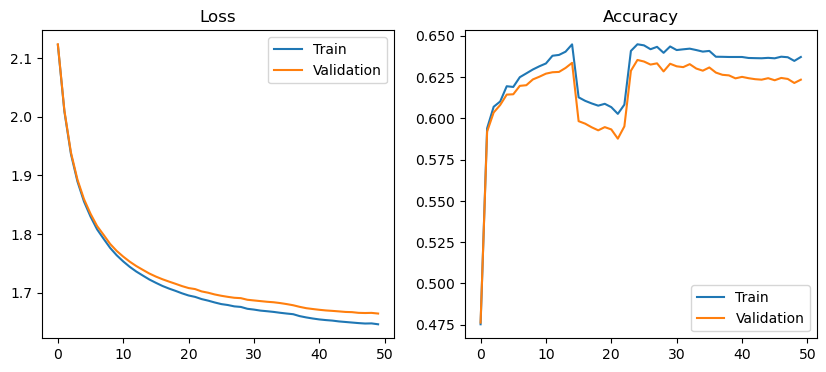

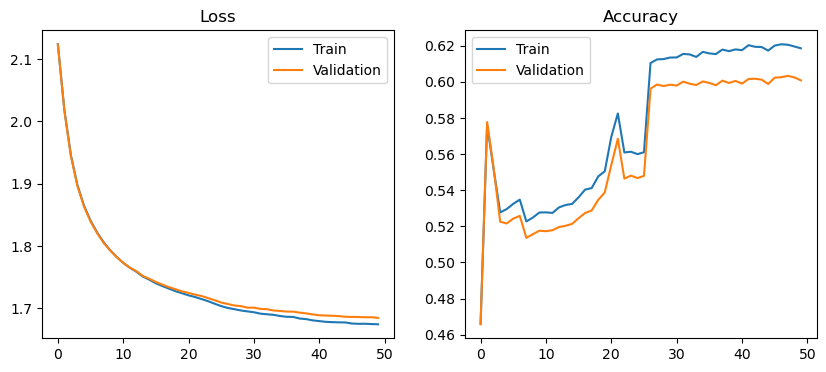

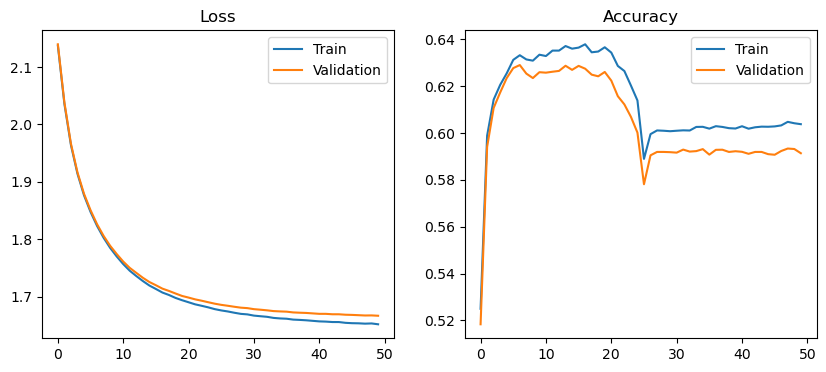

In [138]:
KFoldCrossValidation(Net3, 3, X_train, y_train, X_test, y_test)


## (d)

In [139]:
class Net50(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024,50), # only the weights times input plus bias
            nn.Sigmoid(),
            nn.Linear(50,10),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

Fold 0:
Net50 - Number of parameters: 51760


func: train took: 42.0094 sec
Training accuracy: 0.9782000000000016
Test accuracy: 0.9583999999999999
Fold 1:
Net50 - Number of parameters: 51760


func: train took: 41.5923 sec
Training accuracy: 0.9814500000000007
Test accuracy: 0.9569999999999997
Fold 2:
Net50 - Number of parameters: 51760


func: train took: 42.5860 sec
Training accuracy: 0.9791750000000011
Test accuracy: 0.9572999999999995
Final results:
Training accuracy: 0.9796083333333345+/-0.001361728884747099
Test accuracy: 0.9575666666666663+/-0.0006018490028423799


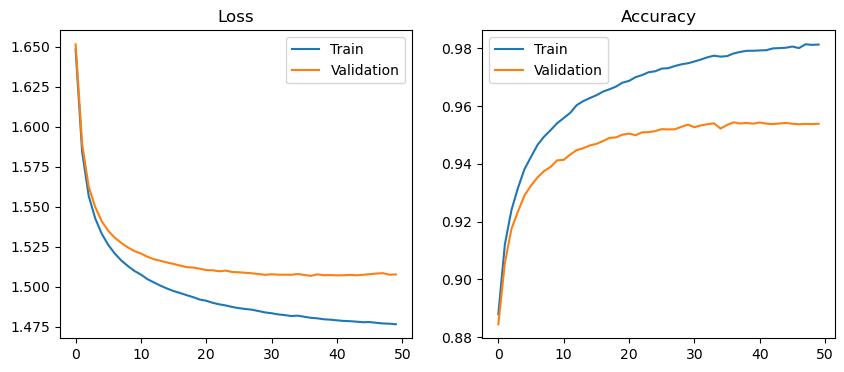

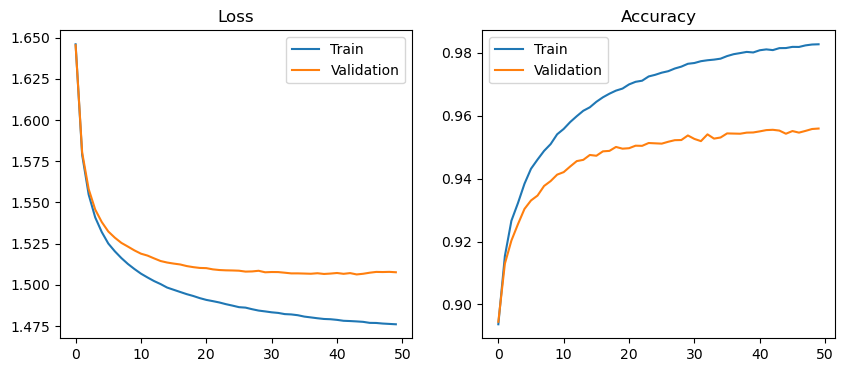

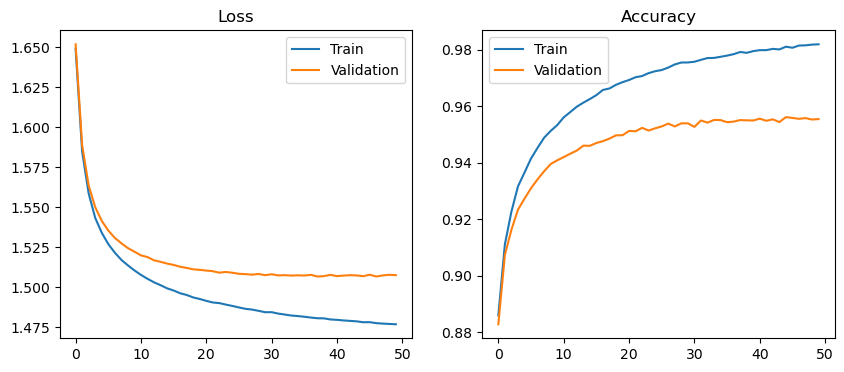

In [140]:
KFoldCrossValidation(Net50, 3, X_train, y_train, X_test, y_test)

### Bias-Variance tradeoff

Bias is the inherent error associated with the training data, and it is related to underfitting. Variance is associated with overfitting and is prevalent when we see a large gap between the train and validation error. We can see here that there is slight overfitting (high variance) and no underfitting (low bias) because the validation loss curve slopes upwards.

# Question 2

## (a)

In [144]:
class Net50Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 50),
            nn.Dropout(p=0.15),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Dropout(p=0.15),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

Fold 0:
Net50Dropout - Number of parameters: 51760


func: train took: 43.0253 sec
Training accuracy: 0.9708750000000012
Test accuracy: 0.9519999999999996
Fold 1:
Net50Dropout - Number of parameters: 51760


func: train took: 43.1878 sec
Training accuracy: 0.9728250000000016
Test accuracy: 0.9522999999999996
Fold 2:
Net50Dropout - Number of parameters: 51760


func: train took: 45.1156 sec
Training accuracy: 0.9740250000000017
Test accuracy: 0.9524999999999998
Final results:
Training accuracy: 0.9725750000000014+/-0.0012980754985749475
Test accuracy: 0.9522666666666663+/-0.00020548046676569399


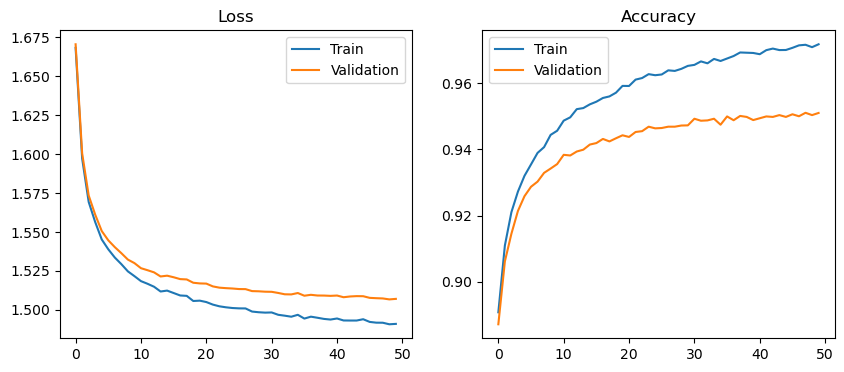

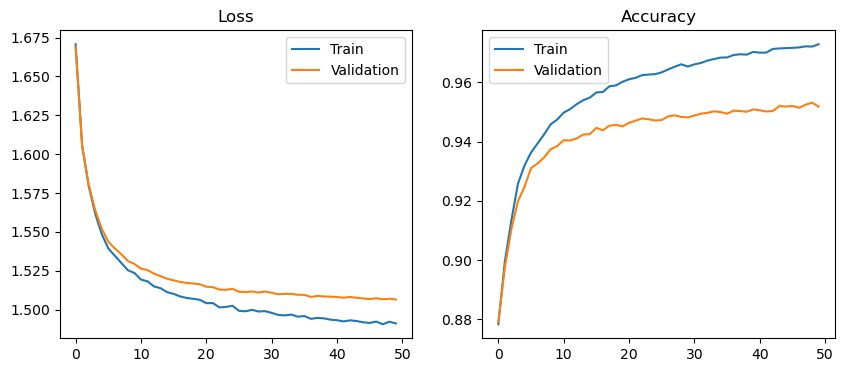

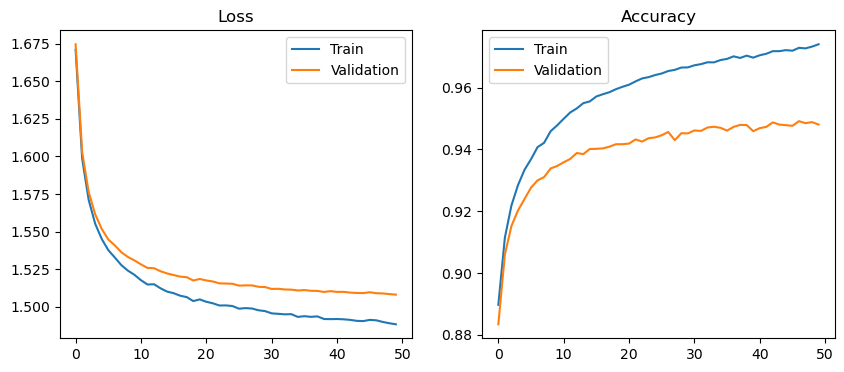

In [145]:
KFoldCrossValidation(Net50Dropout, 3, X_train, y_train, X_test, y_test)

### Compare training and test accuracy

The training and test accuracy for the ANN with dropout is about the same as the training and test accuracy without dropout in 1d. There is slight overfitting, but less than the variance in 1d. 

## (b)

Fold 0:
Net50 - Number of parameters: 51760


func: train took: 42.6464 sec
Training accuracy: 0.9800500000000013
Test accuracy: 0.9614999999999994
Fold 1:
Net50 - Number of parameters: 51760


func: train took: 42.4771 sec
Training accuracy: 0.9814750000000019
Test accuracy: 0.9639999999999993
Fold 2:
Net50 - Number of parameters: 51760


func: train took: 42.8244 sec
Training accuracy: 0.9810000000000014
Test accuracy: 0.9636999999999997
Final results:
Training accuracy: 0.980841666666668+/-0.000592429086239419
Test accuracy: 0.9630666666666662+/-0.0011145502331534102


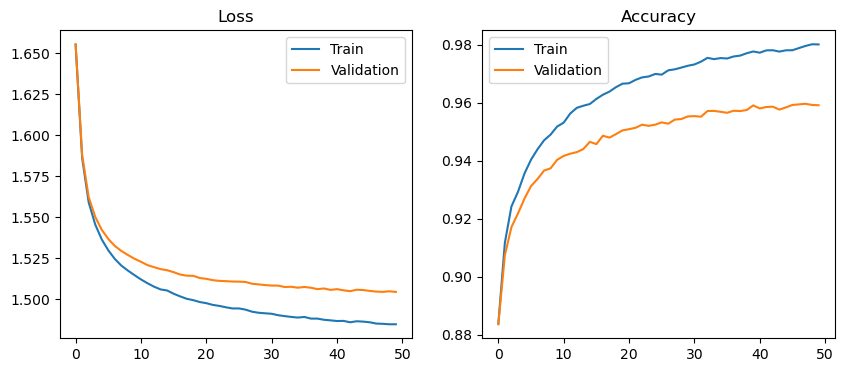

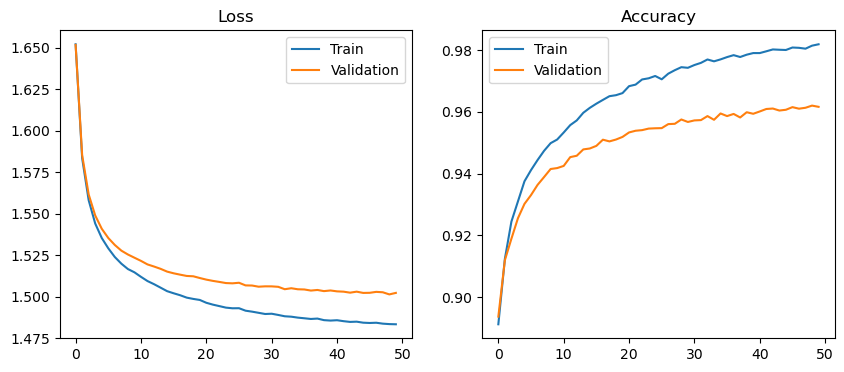

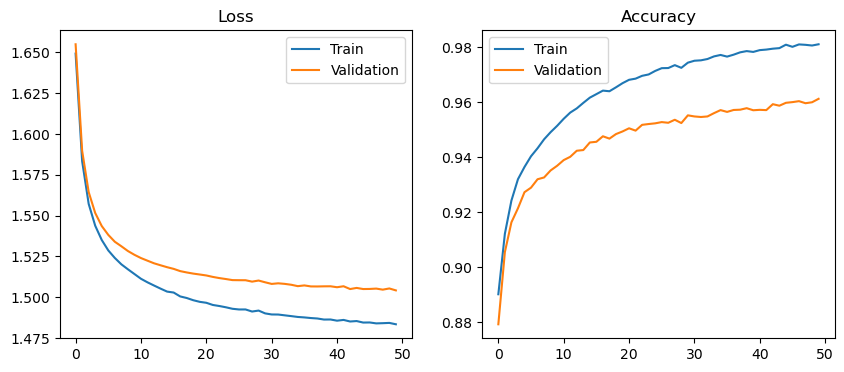

In [146]:
# L2 Regularizaiton by setting the "l2" parameter in KFoldCrossValidation
KFoldCrossValidation(Net50, 3, X_train, y_train, X_test, y_test, l2=1e-5)

### Compare result

The training and test accuracy is slightly higher with an l2 regularization than in 1d without any regularization.

## (c)

*For debugging*: You should get 331 features.

In [147]:
from sklearn.decomposition import PCA

# keeping amount of variance
pca = PCA(n_components=0.99)
# fit
pca.fit(X_train)
# transform
X_train_pca = torch.tensor(pca.transform(X_train), dtype = torch.float)
X_test_pca = torch.tensor(pca.transform(X_test), dtype = torch.float)
print(X_train_pca.shape, X_test_pca.shape)

torch.Size([60000, 331]) torch.Size([10000, 331])


In [154]:
# Use one hidden layer of size 50, no Dropouts
class Net50PCA(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(331,50),
            nn.Sigmoid(),
            nn.Linear(50,10),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

Fold 0:
Net50PCA - Number of parameters: 17110


func: train took: 37.6621 sec
Training accuracy: 0.9740750000000018
Test accuracy: 0.9485000000000002
Fold 1:
Net50PCA - Number of parameters: 17110


func: train took: 37.9003 sec
Training accuracy: 0.9748500000000022
Test accuracy: 0.949
Fold 2:
Net50PCA - Number of parameters: 17110


func: train took: 37.1945 sec
Training accuracy: 0.9739000000000021
Test accuracy: 0.9514
Final results:
Training accuracy: 0.9742750000000021+/-0.00041281553588346366
Test accuracy: 0.9496333333333334+/-0.0012657891697364508


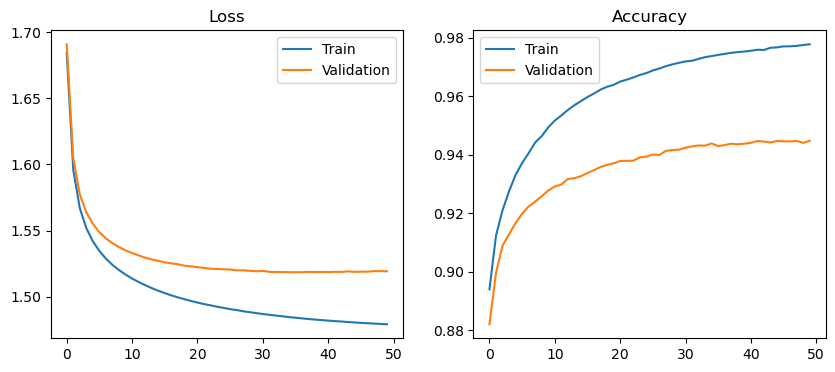

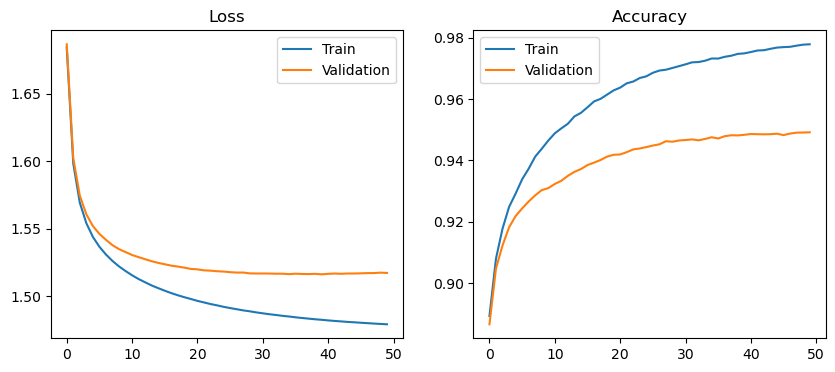

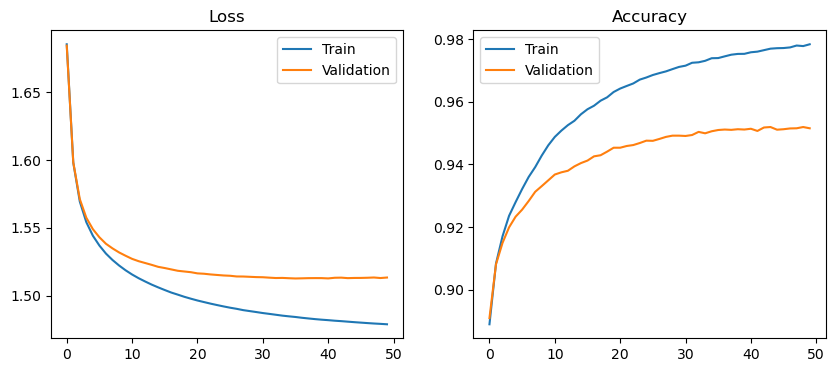

In [155]:
KFoldCrossValidation(Net50PCA, 3, X_train_pca, y_train, X_test_pca, y_test)

### Compare parameters

In this case, we have 17110 whereas we previously had 51760 parameters. This is a signinficant reduction in parameters. 

## (d)

In [ ]:
# If you find Dropout is better, finish this Net50PCADropout and do K-Fold CrossValidation

# class Net50PCADropout(nn.Module):
#     def __init__(self):
#         super().__init__()
#         ...
    
#     def forward(self, x):
#         return ...

In [ ]:
# If you find L2 Regularization is better, 
# just call KFoldCrossValidation with Net50PCA and l2 set to non-zeros

Fold 0:
Net50PCA - Number of parameters: 17110


func: train took: 39.9247 sec
Training accuracy: 0.9756250000000016
Test accuracy: 0.9556999999999994
Fold 1:
Net50PCA - Number of parameters: 17110


func: train took: 40.3921 sec
Training accuracy: 0.9750750000000021
Test accuracy: 0.9541999999999996
Fold 2:
Net50PCA - Number of parameters: 17110


func: train took: 40.0995 sec
Training accuracy: 0.9762250000000013
Test accuracy: 0.9581999999999992
Final results:
Training accuracy: 0.9756416666666684+/-0.0004696334267865234
Test accuracy: 0.9560333333333327+/-0.001649915822768429


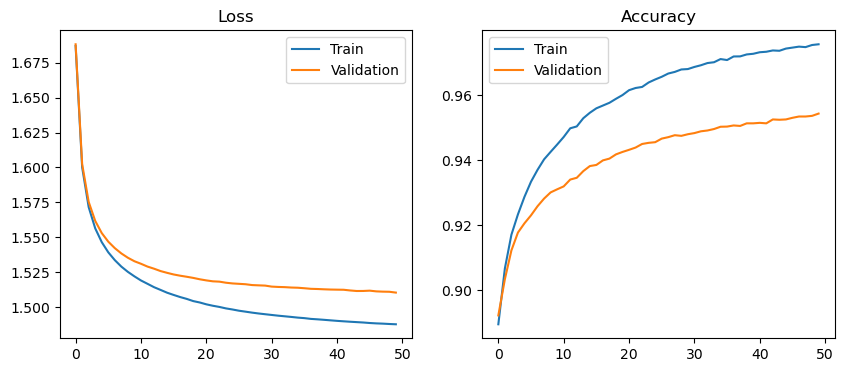

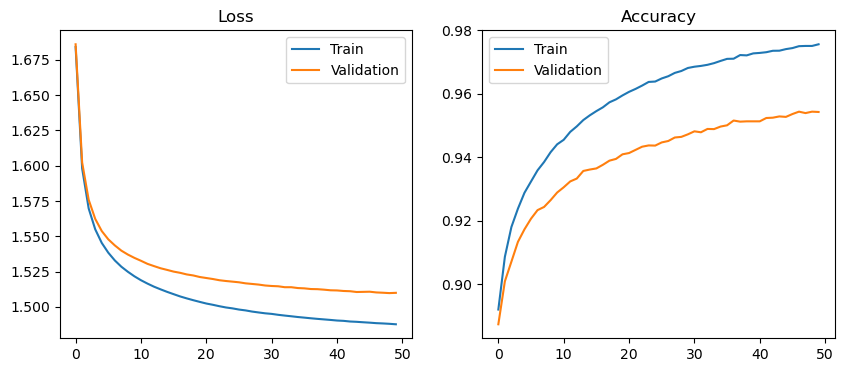

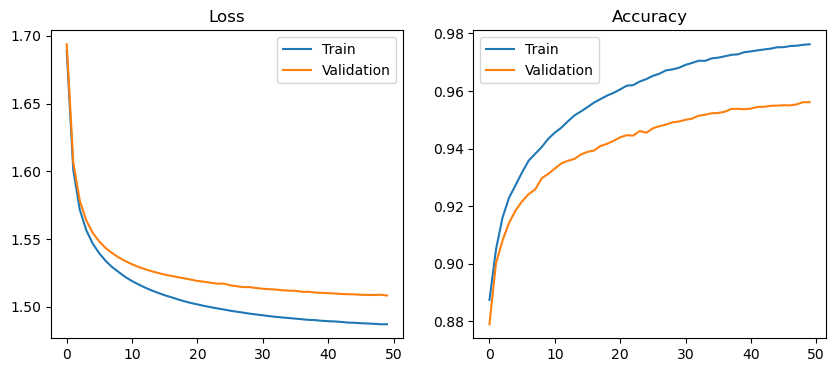

In [160]:
KFoldCrossValidation(Net50PCA, 3, X_train_pca, y_train, X_test_pca, y_test, l2=1e-5)

### Final comparison

I used L2 regularization with the PCA data transformation. The training takes around 40 seconds, which is faster than 1d. The training and testing accuracy is about the same as in 1d.